<a href="https://colab.research.google.com/github/serhataksoy/CompLightLab/blob/main/CompLightLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2 as cv
import torch
import matplotlib.pyplot as plt
import torchvision.io
from torchvision.transforms import transforms
from PIL import Image
import math

In [2]:
image = torchvision.io.read_image('/content/drive/MyDrive/CompLightLab/14135136623_3973d3f03c_z.jpg')
gray_img = torchvision.transforms.functional.rgb_to_grayscale(image)

In [3]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.real(np.transpose(npimg, (1,2,0))), interpolation='gaussian')

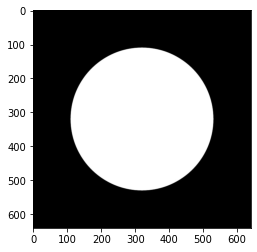

In [4]:
plt.imshow(transforms.ToPILImage()(gray_img),"gray")

In [ ]:
gray_img.size()

torch.Size([1, 640, 640])

In [5]:
def gaussianHP(D0,imgShape):
    dim = image.shape[0]
    rows, cols = image.shape[1:3]
    base = torch.zeros(1,rows,cols)
    center = (rows/2,cols/2)

    for x in range(cols):
        for y in range(rows):
            base[0][y][x] = 1 - math.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

def gaussianLP(D0,imgShape):
    dim = image.shape[0]
    rows, cols = image.shape[1:3]
    base = torch.zeros(1,rows,cols)
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[0][y][x] = math.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

In [6]:
tr1 = transforms.ToTensor()
def distance(point1,point2):
    return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def ConvWithFFT(image):
  im1 = Image.Image.split(transforms.ToPILImage()(image))
  d,h,w = image.size()
  output = torch.zeros(image.size())
  for i in range(0,d):
    fft_img = torch.fft.fft2(tr1(im1[i]))
    im_fft = torch.fft.fftshift(fft_img)
    output[i] = im_fft.float() * gaussianLP(50,image.shape)
    output[i] = torch.fft.fftshift(output[i]) #i
    output[i] = torch.fft.ifft2(output[i])
    #output[i] = output[i]/output[i].real.max()
  plt.imshow(transforms.ToPILImage()(output),"gray")
  return output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:250.)
  if sys.path[0] == '':


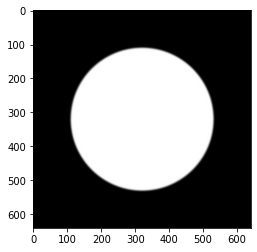

In [7]:
blur = ConvWithFFT(gray_img)

In [8]:
def ConvWithTorchF(image,kernel):
  im1 = Image.Image.split(transforms.ToPILImage()(image))
  channel = torchvision.transforms.functional.get_image_num_channels(image)
  width,height = torchvision.transforms.functional.get_image_size(image)
  KernelWidth,KernelHeight = torchvision.transforms.functional.get_image_size(kernel)
  FınalImg = torch.zeros((channel,height-KernelHeight+1,width-KernelWidth+1))
  
  for i in range(0,channel):
    FınalImg[i] = F.conv2d(tr1(im1[i]), kernel)
  plt.imshow(transforms.ToPILImage()(FınalImg))
  return FınalImg

In [9]:
def kernelToWeight(kernel):
  kernel = kernel.view(1,1,3,3).repeat(1,1,1,1)
  return kernel

In [10]:
def conv(img,kernel):
  channel = torchvision.transforms.functional.get_image_num_channels(img)
  width,height = torchvision.transforms.functional.get_image_size(img)
  KernelWidth,KernelHeight = torchvision.transforms.functional.get_image_size(kernel)
  FınalImg = torch.zeros((channel,height-KernelHeight+1,width-KernelWidth+1))

  for dim in range(channel):  
    for i in range(height-KernelHeight+1):
      for j in range(width-KernelWidth+1):
        sum = 0 
        for k in range(KernelHeight):
          for l in range(KernelWidth):
            sum += (img[dim][i+k][j+l])*(kernel[k,l])
        FınalImg[dim][i][j] = sum
  return FınalImg

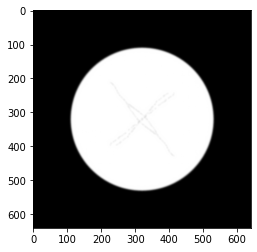

In [12]:
goal_image = torchvision.io.read_image('/content/drive/MyDrive/CompLightLab/pixil-frame-0.jpg')
goal_img = torchvision.transforms.functional.rgb_to_grayscale(goal_image)
goal_img = ConvWithFFT(goal_img)

In [ ]:
goal_img.max()

tensor(1.)

In [40]:
blur = torch.round(blur, decimals = 2)

In [41]:
goal_img = torch.round(goal_img, decimals = 2)

In [17]:
from numpy import linalg as LA

In [18]:
def norm_error(image1,image2):
  error = image1-image2
  norm_error = LA.norm(error)
  return norm_error  

In [ ]:
norm_error = norm_error(blur,goal_img)

In [ ]:
import random

In [ ]:
random.randint(0,1)

1

In [ ]:
def takeSecond(elem):
    return elem[1]

In [ ]:
Rkernel = torch.randint(0,2,goal_img.size()[1:])

In [ ]:
Rkernel.size()

torch.Size([640, 640])

In [ ]:
blur.min()

tensor(-0.)

In [ ]:
if Rkernel.max()-blur.max() == 0:
  print('hi')

hi


In [ ]:
error = blur-goal_image
#error = torch.round(error, decimals = 2)

In [ ]:
blur.max()

tensor(1.)

In [ ]:
goal_img.max()

tensor(1.)

In [ ]:
if error[0][0][0] == 0:
  print('hi')

hi


In [ ]:
def EvoKernelOpt(image,goal_image):
  step_size = 0
  Rkernel = torch.randint(0,2,image.size()[1:]) 
  error = image-goal_image
  error += error.min()
  for i in range(640):
    for j in range(640):
      if error[0][i][j] == 0:
        Rkernel[i][j] = 1
  error = (image*Rkernel) - goal_image
  norm_error = LA.norm(error)
  storage = []
  Kstorage = []
  print(norm_error)
  for i in range(640):
      for j in range(640):
        if Rkernel[i][j] == 1:
          storage.append((i,j))
  #print(storage)
  #print(Kstorage)
  while step_size<1000:
     print(step_size)
     Genkernel = torch.randint(0,2,image.size()[1:])
     for i in range(len(storage)):
       k,l = storage[i]
       Genkernel[k][l] = 1

     gen_img = Genkernel * image
     error = gen_img - goal_img
     new_norm_error = LA.norm(error)
     if new_norm_error < norm_error:
       Kstorage.append((Genkernel,new_norm_error))
       Rkernel = Genkernel
       norm_error = new_norm_error

     step_size += 1
  


  return Kstorage


In [ ]:
def fullyRandomKernel(image,goal_image):
  step_size = 0
  Rkernel = torch.randint(0,2,image.size()[1:]) 
  error = image-goal_image
  error = torch.round(error, decimals = 2)
  error = (image*Rkernel) - goal_image
  norm_error = LA.norm(error)
  print(norm_error)
  #print(storage)
  #print(Kstorage)
  Kstorage = []
  while step_size<1000:
     print(step_size)
     Genkernel = torch.randint(0,2,image.size()[1:]) 

     gen_img = Genkernel * image
     error = gen_img - goal_img
     new_norm_error = LA.norm(error)

     Kstorage.append((Genkernel,new_norm_error))
     #norm_error = new_norm_error

     step_size += 1
  #BestGen = Kstorage.sort(key=takeSecond)


  return Kstorage


In [ ]:
Gen = EvoKernelOpt(blur,goal_img)

261.39932
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274


In [ ]:
Gen.sort(key=takeSecond)

In [ ]:

norm_error = LA.norm(error)

In [ ]:
norm_error

3.1840954

In [107]:
Rkernel = torch.randint(0,2,image.size()[1:]) 
error = blur-goal_img
for i in range(640):
  for j in range(640):
    if error[0][i][j] == 0:
      Rkernel[i][j] = 1
      

In [113]:
Rkernel[0][1]

tensor(1)

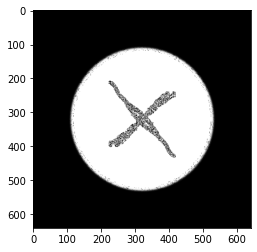

In [114]:
plt.imshow(transforms.ToPILImage()(Rkernel*blur),"gray")


In [ ]:
error.max()

tensor(1.)

In [ ]:
error = blur-goal_image
error = torch.round(error, decimals = 2)

In [ ]:
error += error.min()

In [ ]:
storage = [(2,3),(2,5)]


In [ ]:
i,j = storage[0]

In [ ]:
j

3

In [15]:
!pip install pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.3 MB/s 


In [16]:
import pygad

In [20]:
fitness_function = norm_error

num_generations = 50
num_parents_mating = 4

sol_per_pop = 8
num_genes = 640*640

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

In [21]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

In [22]:
ga_instance.run()

array([-2.15323322, -0.62020713, -1.35386629, ...,  1.53106802,
        0.53196206,  0.45708985])

In [27]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

prediction = numpy.sum(numpy.array(function_inputs)*solution)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

Parameters of the best solution : [-2.15323322 -0.62020713 -1.35386629 ...  1.53106802  0.53196206
  0.45708985]
Fitness value of the best solution = 3817.929301085223


NameError: ignored

In [35]:
import functools
import operator

In [29]:
def img2chromosome(img_arr):

    return numpy.reshape(a=img_arr, newshape=(functools.reduce(operator.mul, img_arr.shape)))

In [30]:
def chromosome2img(vector, shape):
    # Check if the vector can be reshaped according to the specified shape.
    if len(vector) != functools.reduce(operator.mul, shape):
        raise ValueError("A vector of length {vector_length} into an array of shape {shape}.".format(vector_length=len(vector), shape=shape))

    return numpy.reshape(a=vector, newshape=shape)

In [83]:
target_chromosome = img2chromosome(goal_img)

In [42]:
blur.max()

tensor(1.)

In [43]:
blur.min()

tensor(-0.)

In [78]:
def fitness_fun(solution, solution_idx):
    fitness = numpy.sum(numpy.abs(target_chromosome-solution))

    fitness = numpy.sum(target_chromosome) - fitness
    return fitness

In [92]:
target_im = goal_img
ga_instance = pygad.GA(num_generations=20000,
                       num_parents_mating=10,
                       fitness_func=fitness_fun,
                       sol_per_pop=20,
                       num_genes=target_im.size,
                       init_range_low=0.0,
                       init_range_high=1.0,
                       mutation_percent_genes=0.01,
                       mutation_type="random",
                       mutation_by_replacement=True,
                       random_mutation_min_val=0.0,
                       random_mutation_max_val=1.0)

In [82]:
goal_img = goal_img.numpy()[:, :, :]

AttributeError: ignored

In [55]:
len(goal_img)

1

In [93]:
ga_instance.run()

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:3279: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


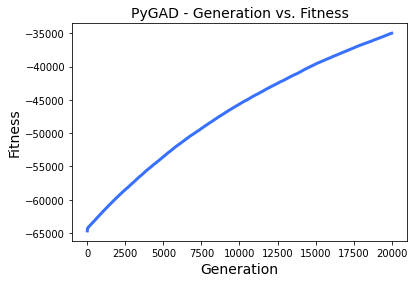

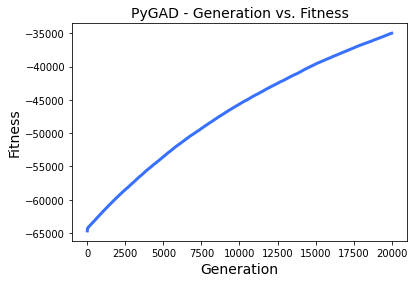

In [94]:
ga_instance.plot_result()


In [95]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

Fitness value of the best solution = -35002.924541133165
Index of the best solution : 14


In [64]:
len(solution)

409600

TypeError: ignored

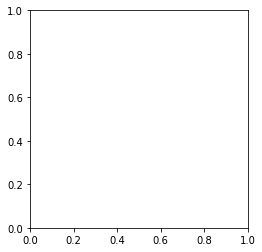

In [96]:
import matplotlib.pyplot

result = chromosome2img(solution, target_im.shape)
matplotlib.pyplot.imshow(result)
matplotlib.pyplot.show()

In [97]:
result = torch.from_numpy(result)

In [98]:
result.size()

torch.Size([1, 640, 640])

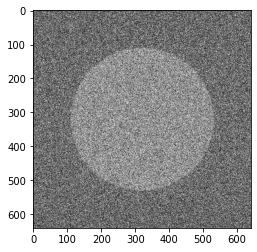

In [99]:
plt.imshow(transforms.ToPILImage()(result),'gray')

In [119]:
fft_img = torch.fft.fft2(blur)

plt.imshow(transforms.ToPILImage()(fft_img.uint8),"gray")
im_fft = torch.fft.fftshift(fft_img)

AttributeError: ignored